In [1]:
#Choose the ATLAS ML training  kernel from the dropdown menu!
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,ZeroPadding2D, BatchNormalization, Activation, Layer, Conv2D,AveragePooling2D,UpSampling2D,Reshape,Flatten
from tensorflow.keras import backend as K

In [2]:
# Must be TF version 2
print(tf.__version__)

2.9.1


In [3]:
from func import load_model, save_model, SetStyle
SetStyle()

## Load background dataset

In [4]:
dataset_folder = '/global/cfs/cdirs/ntrain5/atlas-ml-training/anomaly_detection/'
# You should already have run
# python create_datasets.py --bkg_file background_for_training.h5 --output_bkg_name 'BKG' --signals_files 'Ato4l_lepFilter_13TeV.h5' --output_signal_names 'Ato4l_lepFilter_13TeV' --events=1000000
filename = 'BKG_dataset.h5'

In [5]:
# load background training data
with h5py.File(dataset_folder+filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)
X_train = np.reshape(X_train, (-1, 19,3,1))
X_test = np.reshape(X_test, (-1, 19,3,1))
X_val = np.reshape(X_val, (-1, 19,3,1))

print(X_train.shape)

(640000, 57)
(640000, 19, 3, 1)


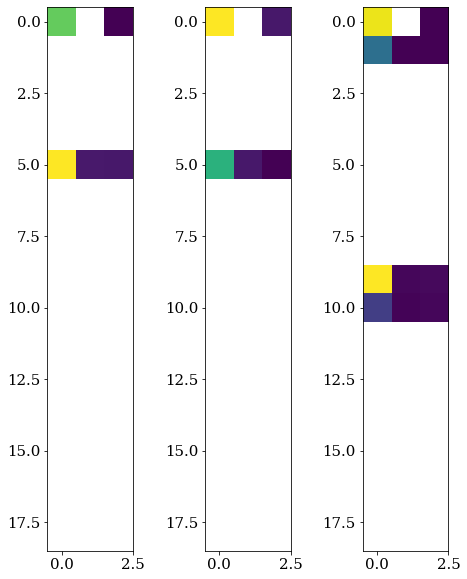

In [6]:
#Plot one of these pictures
plt.figure(figsize=(8,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    to_plot = X_train[i].copy()
    to_plot[to_plot == 0.0] = np.nan
    plt.imshow(to_plot, interpolation='none')

## Define the CNN autoencoder <img src="assets/cnn_AE.png" width=600 height=400 />

In [7]:
image_shape = (19,3,1)
latent_dimension = 8
num_node=10
activation = "swish"

In [8]:
#encoder
input_encoder = Input(shape=(image_shape))
x = Conv2D(num_node, kernel_size=(3, 3),
         use_bias=False, padding='same',activation=activation)(input_encoder)
x = AveragePooling2D(pool_size = (2, 1))(x)
x = Flatten()(x)
enc = Dense(latent_dimension,activation='relu')(x)
encoder = Model(inputs=input_encoder, outputs=enc)
#decoder
x = Dense(num_node*9*3,activation=activation)(enc)
x = Reshape((9,3,num_node))(x)
x = UpSampling2D((2, 1))(x)
x = ZeroPadding2D(((1, 0),(0,0)))(x)
dec = Conv2D(1, kernel_size=(3,3), use_bias=False,padding='same',activation='linear')(x)


autoencoder = Model(inputs=input_encoder, outputs=dec)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 3, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 19, 3, 10)         90        
                                                                 
 average_pooling2d (AverageP  (None, 9, 3, 10)         0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 270)               0         
                                                                 
 dense (Dense)               (None, 8)                 2168      
                                                                 
 dense_1 (Dense)             (None, 270)               2430      
                                                           

2022-07-29 10:30:51.854229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 10:30:52.461666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14637 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [9]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

## Trainning and saving the model

In [10]:
EPOCHS = 50
BATCH_SIZE = 10000

In [11]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/50


2022-07-29 10:30:54.313841: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


64/64 [==============================] - 2s 10ms/step - loss: 70.1730 - val_loss: 45.4779
Epoch 2/50
64/64 [==============================] - 0s 6ms/step - loss: 23.8417 - val_loss: 10.7717
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 7.6389 - val_loss: 5.8197
Epoch 4/50
64/64 [==============================] - 0s 6ms/step - loss: 4.8892 - val_loss: 4.2835
Epoch 5/50
64/64 [==============================] - 0s 6ms/step - loss: 3.7144 - val_loss: 3.3602
Epoch 6/50
64/64 [==============================] - 0s 6ms/step - loss: 2.9965 - val_loss: 2.7902
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 2.5499 - val_loss: 2.4227
Epoch 8/50
64/64 [==============================] - 0s 6ms/step - loss: 2.2521 - val_loss: 2.1647
Epoch 9/50
64/64 [==============================] - 0s 6ms/step - loss: 2.0346 - val_loss: 1.9596
Epoch 10/50
64/64 [==============================] - 0s 6ms/step - loss: 1.8420 - val_loss: 1.7542
Epoch 11/50
64/64 [======

In [12]:
model_name = 'CNN_AE'
model_directory = 'CNNS/'
if not os.path.exists(model_directory+model_name):
    os.makedirs(model_directory+model_name)
save_model(model_directory+model_name, autoencoder)

## Let's take a look at the background reconstruction

In [13]:
bkg_prediction = autoencoder.predict(X_test,batch_size=1000)

6250/6250 [==============================] - 6s 896us/step


## Now let's take a look at the signals! <img src="assets/NP.png" width=800 height=200 />

In [14]:
# add correct signal labels
signal_labels = ['A to 4 leptons',
                 'h to tau tau',
                 'leptoquark',
                 'charged h to tau nu']

In [15]:
# add correct path to signal files
signals_file = ['Ato4l_lepFilter_13TeV_dataset.h5',
                'hToTauTau_13TeV_PU20_dataset.h5',
                'leptoquark_LOWMASS_lepFilter_13TeV_dataset.h5',
                'hChToTauNu_13TeV_PU20_dataset.h5']

In [16]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(dataset_folder+signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)

In [17]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(signal_data[i].reshape(-1,19,3,1),batch_size=1000)
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

761/761 [==============================] - 1s 1ms/step


## Before looking into the results, let's save the trained model in case we want to use it again

In [18]:
save_file = 'cnnae_results'

In [19]:
with h5py.File(save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' %sig[0], data=sig[1])
        file.create_dataset('%s_predicted' %sig[0], data=sig[2])

# Evaluating the autoencoder
## Let's take a look at the reconstruction error for the different signals and background

In [20]:
from func import mse_loss


In [21]:
# compute loss value (true, predicted)
total_loss = []
shape=(-1,X_test.shape[1]*X_test.shape[2])
total_loss.append(mse_loss(X_test.reshape(shape),bkg_prediction.reshape(shape)))
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X,(signal_results[i][2].reshape(shape))))

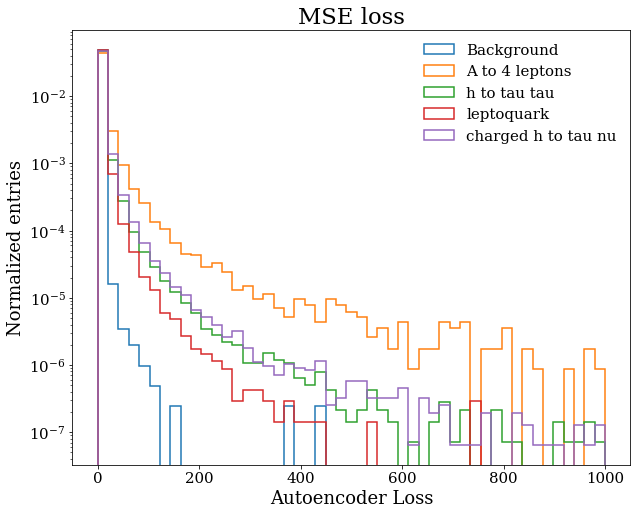

In [22]:
binning=np.linspace(0,1000,50)

plt.figure(figsize=(10,8))
plt.hist(total_loss[0], bins=binning, label="Background", density = True, histtype='step', fill=False, linewidth=1.5)
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i+1], bins=binning, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Normalized entries")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

In [23]:
## Let's now make a Receiver Operating Characteristic (ROC) curve

In [24]:
from sklearn.metrics import roc_curve, auc

In [25]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

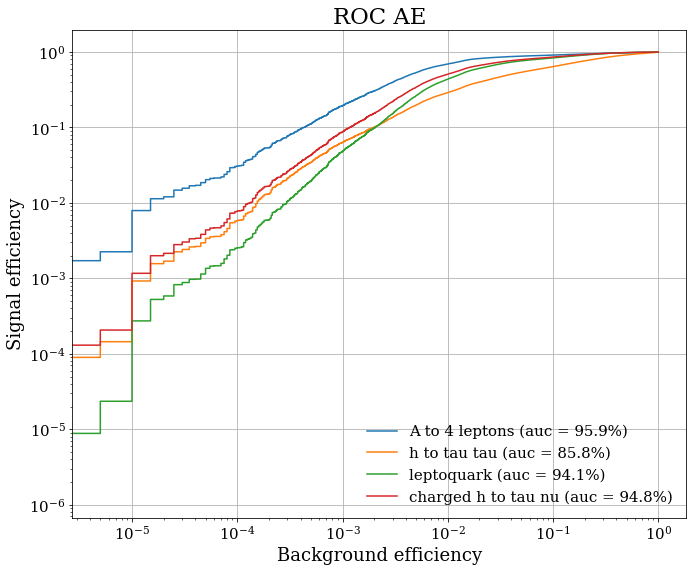

In [26]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("Signal efficiency")
    plt.xlabel("Background efficiency")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
plt.title("ROC AE")
plt.show()

## Let's now make a Significance Improvement (SIC) curve

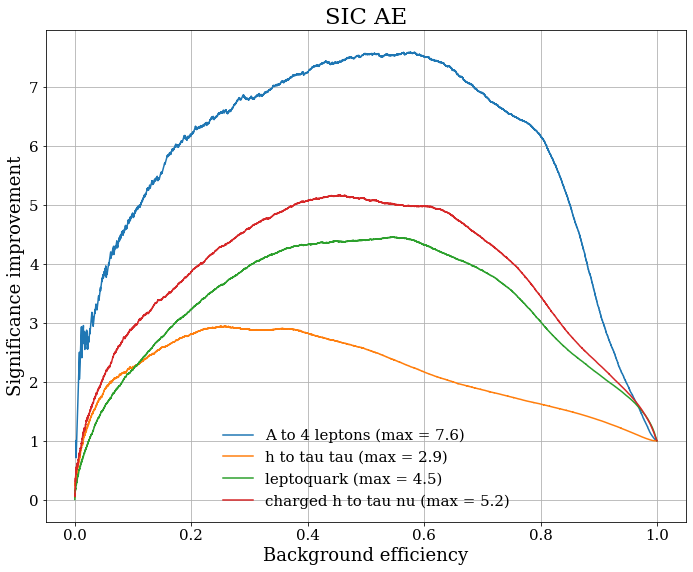

In [30]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)    
    plt.plot(tpr_loss,np.ma.divide(tpr_loss,np.sqrt(fpr_loss)), "-", label='%s (max = %.1f)'%(label,np.max(np.ma.divide(tpr_loss,np.sqrt(fpr_loss)))), linewidth=1.5)
    

    plt.ylabel("Significance improvement")
    plt.xlabel("Background efficiency")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
plt.title("SIC AE")
plt.show()